CE310 Evolutionary Computation and Genetic Programming<br>
Riccardo Poli, Spring 2023
<br>Drew Berry RegNo: 2000878
### Assignment: Programming Assignment and mini project Part 2 (of 2) – Mini project
### Genetic Programming and Symbolic Regression
For information on on symbolic regression see the learning material on Moodle or visit: 
https://en.wikipedia.org/wiki/Symbolic_regression

In [30]:
# Install DEAP toolbox
# https://deap.readthedocs.io/en/master/index.html

# Anaconda:
# easy_install deap

# Google Colab:
!pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
# Import relevant Python modules
import operator
import math
import random
import numpy  as np
from matplotlib import pyplot

# Import DEAP modules
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

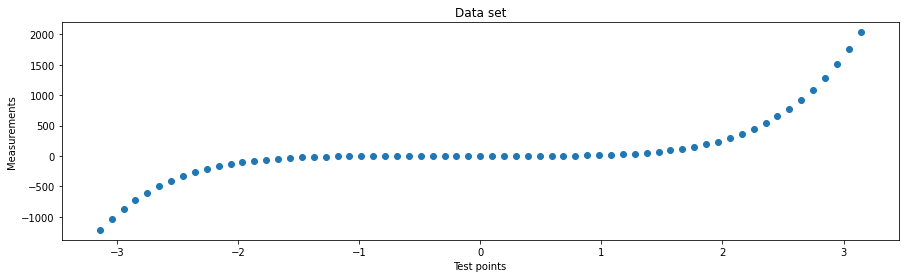

In [297]:
# ====================================================================
# PARAMETERS - change the parameters in this section
# Population size: 500 vs 2000
# Tournament Size: 2 vs 5
# repeat at least 10 times per setting

no_generations = 30   # number of generations
no_population = 2000   # population size
no_tournaments =  5   # tournament size

# other parameters that you can change and explore
p_xo = 0.7  # XO rate
p_m  = 0.3  # Mutation rate
UseSqError = True # use Least Squares approach 

# ====================================================================
# Define your Problems/Target Functions and create sample data
# Assume you make measurments at specific test points:

test_points = np.linspace(-math.pi,math.pi, 65).tolist()
measurement = lambda x: 5 * x ** 5 + 4 * x ** 4 + 3 * x ** 3 + 2 * x ** 2 + x
#measurement = lambda x: 4 * math.sin(5 * math.pi * x / 4)

# ====================================================================

target = np.empty(len(test_points))
for i in range(len(test_points)): target[i] = measurement(test_points[i])

fig, ax = pyplot.subplots(figsize=(15,4))
ax.scatter(test_points, target)
ax.set_xlabel('Test points')
ax.set_ylabel('Measurements')
ax.set_title('Data set')
pyplot.show()

# GP Goal: evolve a function f(x) (mathematical expression or model) with 
# x=test_points that best fits a target dataset

In [298]:
# Define new functions
def protectedDiv(left, right):
    return left / right if right else 1    
    
# create Primitive set & classes 
if "pset" not in globals():
    pset = gp.PrimitiveSet("MAIN", 1)
    pset.addPrimitive(operator.add, 2)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    pset.addPrimitive(protectedDiv, 2)
    pset.addPrimitive(operator.neg, 1)
    pset.addPrimitive(math.cos, 1)
    pset.addPrimitive(math.sin, 1)
    pset.addTerminal(1)
    pset.addTerminal(-1)    
    pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
    pset.renameArguments(ARG0='x')

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)
    
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)


def evalSymbReg(individual):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)

    if UseSqError:
      # squared error
      error = (abs(func(x) - measurement(x))**2 for x in test_points)    
    else:
      # Absolute distance between target curve and solution
      error = (abs(func(x) - measurement(x)) for x in test_points)    

    return math.fsum(error)/len(test_points),


toolbox.register("evaluate", evalSymbReg)
toolbox.register("select", tools.selTournament, tournsize=no_tournaments)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=64))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=64))

random.seed()

pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("mdn", np.median)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, p_xo, p_m, no_generations, stats=mstats,
                                       halloffame=hof, verbose=True)

   	      	                                  fitness                                  	                          size                         
   	      	---------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max       	mdn   	min   	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	2000  	3.87131e+28	0  	2.8455e+31	307590	302862	2000  	8.68975e+29	3.619	0  	7  	3  	2  	2000  	1.48723
1  	1598  	3.07742e+27	1  	2.05161e+30	307499	296289	1598  	7.37166e+28	4.194	1  	13 	3  	1  	1598  	1.92025
2  	1551  	1.05124e+29	2  	8.09943e+31	306045	294982	1551  	2.33155e+30	4.71 	2  	18 	4  	1  	1551  	2.22955
3  	1594  	3.16176e+29	3  	8.09943e+31	305866	282588	1594  	4.18401e+30	5.2415	3  	16 	5  	1  	1594  	2.50243
4  	1596  	3.56158e+29	4  	8.09943e+31	304419	270495	1596  	4.67096e+30	5.988 	4  	20 	5  	1  	1596  	2.86546
5  	1609  	3.5229e+29 	5  	3.23977e+32	304241	270495	1609  	

Fitnes: [3391.3664004063794, 307589.9740985726]
Size: [3.0, 40.0]
Evaluations: 49422


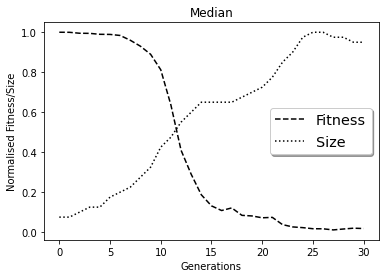

In [299]:
# Plot Fitness and Size
x = np.arange(0, no_generations+1)
s = log.chapters['size'].select("mdn")
f = log.chapters['fitness'].select("mdn")

fig, ax = pyplot.subplots()
ax.plot(x, f/max(f), 'k--', label='Fitness')
ax.plot(x, s/max(s), 'k:', label='Size')
ax.set_xlabel('Generations')
ax.set_ylabel('Normalised Fitness/Size')
ax.set_title('Median')
legend = ax.legend(shadow=True, fontsize='x-large')
print('Fitnes: [' + str(min(f))+', '+str(max(f))+']')
print('Size: [' + str(min(s))+', '+str(max(s))+']')
print('Evaluations: ' +str(sum(log.select("nevals"))))

pyplot.show()

In [300]:
# Best individual 
print(hof[0])

mul(mul(x, add(x, add(1, add(add(x, add(sub(1, -1), add(x, x))), add(add(mul(add(x, add(sin(add(1, x)), x)), x), mul(x, add(x, add(x, x)))), x))))), mul(x, x))


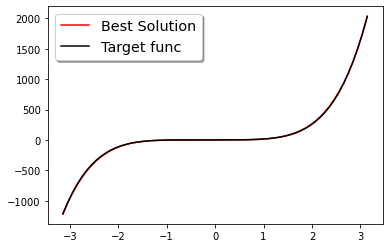

In [302]:
# Plot comparison Tagret vs. evolved solution

x = test_points
f = toolbox.compile(expr=hof[0])

y = np.empty(len(x))
for i in range(len(x)): y[i] = f(x[i])

fig, ax = pyplot.subplots()
ax.plot(x, y, 'r-', label='Best Solution')
ax.plot(x, target, 'k-', label='Target func')
#legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
legend = ax.legend(shadow=True, fontsize='x-large')

pyplot.show()